# Inventory Monitoring at Distribution Centers
Huge warehouses like Amazon requires reliable automated systems that sort and distribute packages. These packages can hold multiple items, therefore an automated system that counts the items in each package is required. Such system needs to be reliable and be able to identify and count items correctly even if the input photo is not very clear. This
capstone project is about developing such system.

## Dependencies

In [1]:
!pip install smdebug torch torchvision tqdm --no-cache-dir

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 210.9 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.19
    Uninstalling botocore-1.24.19:
      Successfully uninstalled botocore-1.24.19
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.27.35 requires botocore==1.29.35, but you have botocore 1.29.37 which is incompatible.
aiobotocore 2.0.1 requires botocore<1.22.9,>=1.22.8, but you have botocore 1.29.37 which is incompatible.
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/pytorch_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
import sagemaker
import boto3
import os
import json
from tqdm import tqdm
import shutil

import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

from sagemaker.analytics import HyperparameterTuningJobAnalytics
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

from sagemaker.debugger import ProfilerConfig, FrameworkProfile
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

import sagemaker
from sagemaker.pytorch import PyTorch

import time
from IPython import display
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot

from sagemaker.predictor import Predictor

from sagemaker.pytorch import PyTorchModel
from PIL import Image

import io
import torch
import numpy as np

import IPython

Matplotlib is building the font cache; this may take a moment.


[2022-12-27 12:45:51.198 ip-172-16-97-141.ec2.internal:11494 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Basic Macros

In [3]:
session = sagemaker.Session()
bucket= session.default_bucket()
print("Default Bucket: {}".format(bucket))
region = session.boto_region_name
print("AWS Region: {}".format(region))
role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

Default Bucket: sagemaker-us-east-1-608722195437
AWS Region: us-east-1
RoleArn: arn:aws:iam::608722195437:role/service-role/AmazonSageMaker-ExecutionRole-20221225T175806


## Data Preparation

The cell below creates a folder called `train_data`, downloads training data and arranges it in subfolders. Each of these subfolders contain images where the number of objects is equal to the name of the folder. For instance, all images in folder `1` has images with 1 object in them. Images are not divided into training, testing or validation sets. If you feel like the number of samples are not enough, you can always download more data (instructions for that can be found [here](https://registry.opendata.aws/amazon-bin-imagery/)). However, we are not acessing you on the accuracy of your final trained model, but how you create your machine learning engineering pipeline.

In [5]:
def download_and_arrange_data():
    s3_client = boto3.client('s3')

    with open('file_list.json', 'r') as f:
        d=json.load(f)

    for k, v in d.items():
        print(f"Downloading Images with {k} objects")
        directory=os.path.join('train_data', k)
        if not os.path.exists(directory):
            os.makedirs(directory)
        for file_path in tqdm(v):
            file_name=os.path.basename(file_path).split('.')[0]+'.jpg'
            s3_client.download_file('aft-vbi-pds', os.path.join('bin-images', file_name),
                             os.path.join(directory, file_name))

#download_and_arrange_data()

100%|██████████| 1228/1228 [01:29<00:00, 13.66it/s]


100%|██████████| 2299/2299 [02:52<00:00, 13.35it/s]


100%|██████████| 2666/2666 [03:20<00:00, 13.32it/s]


100%|██████████| 2373/2373 [02:54<00:00, 13.57it/s]


100%|██████████| 1875/1875 [02:18<00:00, 13.55it/s]


## Dataset
Amazon Bin Image Dataset contains photos of packages with a metadata file that shows the number of items in the package. This dataset will be used to train a model that can count the number of items in each package.

In [4]:
local_data_path = "train_data"

main_dirs = os.listdir(local_data_path)
main_dirs.sort()
num_items = {}
file_lists = {}
for directory in main_dirs:
    file_lists[directory] = [s for s in os.listdir(os.path.join(local_data_path, directory)) if "jpg" in s]
    file_lists[directory].sort()
    num_items[directory] = len(file_lists[directory])
    print(f'There are {num_items[directory]} images with {directory} items in it.')

There are 1228 images with 1 items in it.
There are 2299 images with 2 items in it.
There are 2666 images with 3 items in it.
There are 2373 images with 4 items in it.
There are 1875 images with 5 items in it.


In [5]:
print(num_items.keys())

dict_keys(['1', '2', '3', '4', '5'])


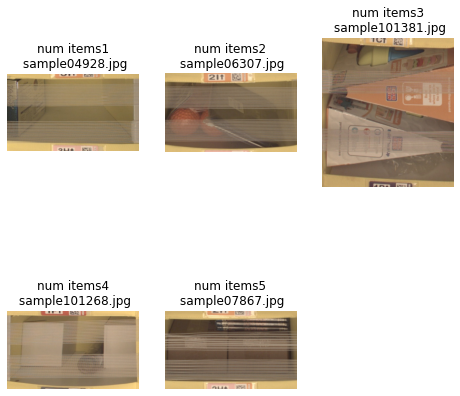

In [6]:
# Show sample of the data

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 2
for key in num_items.keys():
    sample_idx = random.randint(0, num_items[key]-1)
    img_filename = file_lists[key][sample_idx]
    label = "num items" +key + "\n sample"+ img_filename #img_path
    figure.add_subplot(rows, cols, int(key))
    plt.title(label)
    plt.axis("off")
    plt.imshow(mpimg.imread(os.path.join(local_data_path, key, img_filename)).squeeze(), cmap="gray")
plt.show()
figure.savefig('sample_dataset_images.png')

## Dividing dataset into train, test and valid sets

Train 60%, Test: 20%, Valid: 20%

In [8]:
# Select files for each collection
file_list_train = {}
file_list_test = {}
file_list_valid = {}
for key in num_items.keys():
    valid_no = int(0.2*num_items[key])
    test_no = int(0.2*num_items[key])
    train_no =  int(num_items[key] - test_no - valid_no)
    file_list_valid[key] = []
    file_list_test[key] = []
    file_list_train[key] = []
    for idx, filename in enumerate(file_lists[key]):
        if idx < valid_no:
            file_list_valid[key].append(filename)
        elif (idx >= valid_no and idx<(test_no+valid_no)):
            file_list_test[key].append(filename)
        else:
            file_list_train[key].append(filename)
            
    print(f'num items {key}: Valid: {valid_no}, Test: {test_no}, Train: {train_no}')

num items 1: Valid: 245, Test: 245, Train: 738
num items 2: Valid: 459, Test: 459, Train: 1381
num items 3: Valid: 533, Test: 533, Train: 1600
num items 4: Valid: 474, Test: 474, Train: 1425
num items 5: Valid: 375, Test: 375, Train: 1125


In [9]:
subdivided_localdata_path = 'processed_data'

try:
    os.mkdir(subdivided_localdata_path)
    os.mkdir(os.path.join(subdivided_localdata_path, 'valid'))
    os.mkdir(os.path.join(subdivided_localdata_path, 'test'))
    os.mkdir(os.path.join(subdivided_localdata_path, 'train'))
except OSError as error:
    print(error)   

for key in num_items.keys():
    try:
        os.mkdir(os.path.join(subdivided_localdata_path, 'valid', key))
        os.mkdir(os.path.join(subdivided_localdata_path, 'test', key))
        os.mkdir(os.path.join(subdivided_localdata_path, 'train', key))
    except OSError as error:
        print(error)
        
    for filename in file_list_valid[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(subdivided_localdata_path,'valid', key, filename))
    for filename in file_list_test[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(subdivided_localdata_path,'test', key, filename))
    for filename in file_list_train[key]:
        shutil.copy(os.path.join(local_data_path, key, filename), os.path.join(subdivided_localdata_path,'train', key, filename))
        
        
print('Copy completed')

[Errno 17] File exists: 'processed_data'
[Errno 17] File exists: 'processed_data/valid/1'
[Errno 17] File exists: 'processed_data/valid/2'
[Errno 17] File exists: 'processed_data/valid/3'
[Errno 17] File exists: 'processed_data/valid/4'
[Errno 17] File exists: 'processed_data/valid/5'
Copy completed


## Uploading data to S3

In [10]:
subdivided_localdata_path = 'processed_data'
bucket_path = "s3://"+ bucket
database_path = os.path.join(bucket_path, subdivided_localdata_path)
print(f"Bucket: {bucket_path}")
print(f"Dataset: {database_path}")

Bucket: s3://sagemaker-us-east-1-608722195437
Dataset: s3://sagemaker-us-east-1-608722195437/processed_data


In [11]:
os.environ["DATABASE_PATH"] = database_path
os.environ["DATABASE_ORIGIN_PATH"] = subdivided_localdata_path
#!aws s3 sync ${DATABASE_ORIGIN_PATH} ${DATABASE_PATH}

## Model Training

This is the part where the model is trained, the following cells uses hpo.py and train.py

## Hyperparameter Tuning

In [12]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]


In [13]:
estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name='Amazon Packages',
    role=role,
    framework_version="1.8.0",
    instance_count=1,
    instance_type="ml.m5.xlarge",
    py_version='py36'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=10,
    objective_type=objective_type
)

In [14]:
os.environ["SM_CHANNEL_TRAINING"] = database_path # where database is located
os.environ['SM_MODEL_DIR']= bucket_path+ "/model/" # where model will be stored
tuner.fit({"training": database_path}, wait = False)

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


In [15]:
latest_hyperparameter_tuning_job_name = tuner.latest_tuning_job.name
print(latest_hyperparameter_tuning_job_name)

pytorch-training-221227-1249


## Show Tuning Results

In [16]:
exp = HyperparameterTuningJobAnalytics(
  hyperparameter_tuning_job_name=latest_hyperparameter_tuning_job_name)

jobs = exp.dataframe()

jobs.sort_values('FinalObjectiveValue', ascending=0)

,batch_size,learning_rate,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,"""512""",0.072339,pytorch-training-221227-1249-010-91f3904d,Completed,100.353004,2022-12-27 12:51:29+00:00,2022-12-27 12:59:58+00:00,509.0
4,"""256""",0.044196,pytorch-training-221227-1249-006-e21535c3,Completed,56.932491,2022-12-27 12:51:39+00:00,2022-12-27 12:58:57+00:00,438.0
1,"""512""",0.032275,pytorch-training-221227-1249-009-0c6ef03f,Completed,28.532600,2022-12-27 12:51:28+00:00,2022-12-27 12:59:51+00:00,503.0
6,"""128""",0.011980,pytorch-training-221227-1249-004-8a7b5f0d,Completed,4.232887,2022-12-27 12:51:27+00:00,2022-12-27 12:58:16+00:00,409.0
3,"""256""",0.004656,pytorch-training-221227-1249-007-40df89d5,Completed,2.974428,2022-12-27 12:51:26+00:00,2022-12-27 12:58:49+00:00,443.0
5,"""128""",0.004020,pytorch-training-221227-1249-005-4aa09549,Completed,2.126979,2022-12-27 12:51:20+00:00,2022-12-27 12:58:18+00:00,418.0
2,"""512""",0.001556,pytorch-training-221227-1249-008-0cbf78bd,Completed,1.753243,2022-12-27 12:51:36+00:00,2022-12-27 12:59:59+00:00,503.0
7,"""64""",0.009617,pytorch-training-221227-1249-003-fdfad4f9,Completed,1.656549,2022-12-27 12:51:24+00:00,2022-12-27 12:58:12+00:00,408.0
8,"""32""",0.023998,pytorch-training-221227-1249-002-11816428,Completed,1.640996,2022-12-27 12:50:58+00:00,2022-12-27 12:57:48+00:00,410.0
9,"""32""",0.001927,pytorch-training-221227-1249-001-0361e0da,Completed,1.611262,2022-12-27 12:50:57+00:00,2022-12-27 12:57:46+00:00,409.0


In [17]:
best_estimator=tuner.best_estimator()


2022-12-27 12:57:48 Starting - Preparing the instances for training
2022-12-27 12:57:48 Downloading - Downloading input data
2022-12-27 12:57:48 Training - Training image download completed. Training in progress.
2022-12-27 12:57:48 Uploading - Uploading generated training model
2022-12-27 12:57:48 Completed - Resource retained for reuse


In [18]:
best_estimator.hyperparameters()

{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'learning_rate': '0.0019270438362405597',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"Amazon Packages-2022-12-27-12-49-16-627"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-608722195437/Amazon Packages-2022-12-27-12-49-16-627/source/sourcedir.tar.gz"'}

In [19]:
hyperparameter_values = {
    "learning_rate": 0.0019270438362405597,
    "batch_size": 32,
}
hyperparameter_values

{'learning_rate': 0.0019270438362405597, 'batch_size': 32}

## Training on Entire Dataset

In [20]:
# Setting up debugging

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [21]:
# Setting up profiling
debugger_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

In [22]:
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=10,
    instance_type="ml.m5.xlarge",
    entry_point="train.py",
    framework_version="1.8",
    py_version='py36',
    hyperparameters=hyperparameter_values,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [23]:
# Training
os.environ["SM_CHANNEL_TRAINING"] = database_path # where database is located
os.environ['SM_MODEL_DIR']= bucket_path+ "/model/" # where model will be stored
estimator.fit({"training": database_path}, wait=False)
job_name = estimator._current_job_name
print('Job name:', job_name)
debug_artifacts_path = estimator.latest_job_debugger_artifacts_path()
print('Debug artifacts path', debug_artifacts_path)

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2022-12-27-13-04-39-930


Job name: pytorch-training-2022-12-27-13-04-39-930
Debug artifacts path s3://sagemaker-us-east-1-608722195437/pytorch-training-2022-12-27-13-04-39-930/debug-output


## Show Realtime Summary

In [24]:
job_name = estimator.latest_training_job.name
client = estimator.sagemaker_session.sagemaker_client
description = client.describe_training_job(TrainingJobName=estimator.latest_training_job.name)

print(f'job_name: {job_name}')
print(f'client: {client}')

job_name: pytorch-training-2022-12-27-13-04-39-930
client: <botocore.client.SageMaker object at 0x7f40ed8a5a30>


In [25]:
%matplotlib inline

while description["SecondaryStatus"] not in {"Stopped", "Completed", "Failed"}:
    description = client.describe_training_job(TrainingJobName=job_name)
    primary_status = description["TrainingJobStatus"]
    secondary_status = description["SecondaryStatus"]
    print("====================================================")
    print("TrainingJobStatus: ", primary_status, " | SecondaryStatus: ", secondary_status)
    print("====================================================")
    for r in range(len(estimator.latest_training_job.rule_job_summary())):
        rule_summary = estimator.latest_training_job.rule_job_summary()
        print(
            rule_summary[r]["RuleConfigurationName"], ": ", rule_summary[r]["RuleEvaluationStatus"]
        )
        if rule_summary[r]["RuleEvaluationStatus"] == "IssuesFound":
            print(rule_summary[r]["StatusDetails"])
        print("====================================================")
    print("Current time: ", time.asctime())
    display.clear_output(wait=True)
    time.sleep(10) # seconds

TrainingJobStatus:  Completed  | SecondaryStatus:  Completed
VanishingGradient :  Error
Overfit :  Error
Overtraining :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule Overtraining at step 629 resulted in the condition being met

PoorWeightInitialization :  IssuesFound
RuleEvaluationConditionMet: Evaluation of the rule PoorWeightInitialization at step 0 resulted in the condition being met

ProfilerReport :  InProgress
Current time:  Tue Dec 27 14:30:32 2022


In [26]:
trial = create_trial(debug_artifacts_path)

[2022-12-27 14:30:42.960 ip-172-16-97-141.ec2.internal:11494 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-608722195437/pytorch-training-2022-12-27-13-04-39-930/debug-output


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [27]:
print("No of TRAIN datapoints {}".format(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN))))
print("No of EVAL datapoints {}".format(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL))))

[2022-12-27 14:31:12.243 ip-172-16-97-141.ec2.internal:11494 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2022-12-27 14:31:13.264 ip-172-16-97-141.ec2.internal:11494 INFO trial.py:210] Loaded all steps
No of TRAIN datapoints 914
No of EVAL datapoints 396


In [28]:
# Plotting functions

def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)
    
    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    fig.savefig('training_debug_values.png')

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


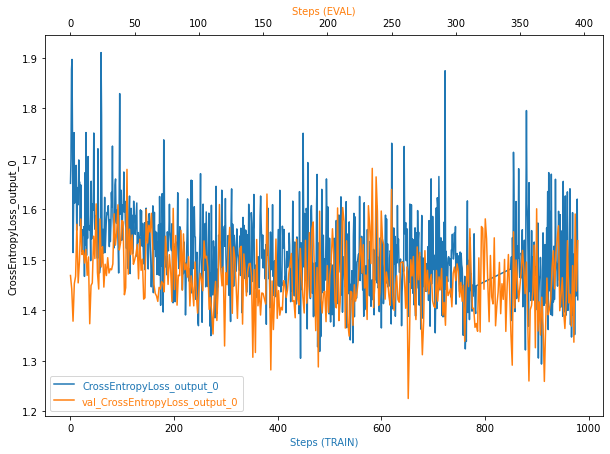

In [29]:
# Plot
plot_tensor(trial, "CrossEntropyLoss_output_0")

In [30]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"Profiler report path:  {rule_output_path}")

Profiler report path:  s3://sagemaker-us-east-1-608722195437/pytorch-training-2022-12-27-13-04-39-930/rule-output


In [31]:
! aws s3 ls {rule_output_path} --recursive

2022-12-27 14:29:23     435057 pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-12-27 14:29:22     283943 pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-12-27 14:29:17        192 pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-12-27 14:29:17        201 pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-12-27 14:29:17       2122 pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-12-27 14:29:17        127 pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-12-27 14:29:17        200 pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-re

In [32]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-608722195437/pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-608722195437/pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json to ProfilerReport/profiler-output/profiler-reports/LowGPUUtilization.json
download: s3://sagemaker-us-east-1-608722195437/pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-608722195437/pytorch-training-2022-12-27-13-04-39-930/rule-output/ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json to ProfilerReport/profiler-output/profiler-reports/LoadBalancing.json
download: s3://sagemaker-us-east

In [33]:
profiler_report_name = [rule["RuleConfigurationName"] for rule in estimator.latest_training_job.rule_job_summary()
                        if "Profiler" in rule["RuleConfigurationName"]
                       ][0]

print(profiler_report_name)
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

ProfilerReport


## Model Deploying and Querying

This is the part where an endpoint is created and then queried using a sample image to check the model output, the following cells uses inference.py file. 

In [34]:
model_location=estimator.model_data
print(model_location)

s3://sagemaker-us-east-1-608722195437/pytorch-training-2022-12-27-13-04-39-930/output/model.tar.gz


In [35]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )

In [36]:
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py36',
                             framework_version='1.8',
                             predictor_cls=ImagePredictor)

In [37]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Creating model with name: pytorch-inference-2022-12-27-14-40-12-144
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2022-12-27-14-40-12-733
INFO:sagemaker:Creating endpoint with name pytorch-inference-2022-12-27-14-40-12-733


------!

In [38]:
# Plot requested image
with open("test_image.jpg", "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)
    Image.open(io.BytesIO(img_bytes))

In [39]:
response=predictor.predict(img_bytes, initial_args={"ContentType": "image/jpeg"})

In [41]:
print("Raw prediction result:")
print(response)
print()

labeled_predictions = list(zip(range(133), response[0]))
print("Labeled predictions: ")
print(labeled_predictions)
print()

labeled_predictions.sort(key=lambda label_and_prob: 1.0 - label_and_prob[1])
print("Most likely answer: {}".format(labeled_predictions[0]))

print(np.argmax(response, 1))
print("Correct answer: 3")

Raw prediction result:
[[-1.4965256452560425, 0.4962218403816223, 0.8560416102409363, 0.9993223547935486, 0.492306649684906]]

Labeled predictions: 
[(0, -1.4965256452560425), (1, 0.4962218403816223), (2, 0.8560416102409363), (3, 0.9993223547935486), (4, 0.492306649684906)]

Most likely answer: (3, 0.9993223547935486)
[3]
Correct answer: 3


In [42]:
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-inference-2022-12-27-14-40-12-733
INFO:sagemaker:Deleting endpoint with name: pytorch-inference-2022-12-27-14-40-12-733
